In [280]:
cd /home/blansdel/projects/mabe/mabetask1/

/home/blansdel/projects/mabe/mabetask1


In [281]:
path = '/home/blansdel/projects/mabe/mabetask1/snapshots/'

In [282]:
import numpy as np
import os
import os.path

In [283]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="8"

In [284]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle 
from matplotlib import rc

import json
import ssm

from mabetask1.lib.config import *
from mabetask1.lib.utils import animate_pose_sequence, plot_annotation_strip, num_to_text, seed_everything, validate_submission

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import sklearn

In [285]:
from mabetask1.grid_searches import sweeps_baseline 
from mabetask1.dl_generators import *
from mabetask1.dl_models import *

In [286]:
class Trainer:
    def __init__(self, *,
               train_data,
               val_data,
               test_data,
               feature_dim, 
               batch_size, 
               num_classes,
               augment=False,
               class_to_number=None,
               past_frames=0, 
               future_frames=0,
               frame_gap=1, 
               use_conv=False, 
               build_model = build_baseline_model,
               Generator = MABe_Generator,
               use_callbacks = False):

        flat_dim = np.prod(feature_dim)
        if use_conv:
            input_dim = ((past_frames + future_frames + 1), flat_dim,)
        else:
            input_dim = (flat_dim * (past_frames + future_frames + 1),)

        self.input_dim = input_dim
        self.use_conv=use_conv
        self.num_classes=num_classes
        self.build_model = build_model 
        self.use_callbacks = False

        c2n = {'other': 0,'investigation': 1,
                    'attack' : 2, 'mount' : 3}
        self.class_to_number = class_to_number or c2n

        self.train_generator = Generator(train_data, 
                                        batch_size=batch_size, 
                                        dim=input_dim,
                                        num_classes=num_classes, 
                                        past_frames=past_frames, 
                                        future_frames=future_frames,
                                        class_to_number=self.class_to_number,
                                        use_conv=use_conv,
                                        frame_gap=frame_gap,
                                        augment=augment,
                                        shuffle=True,
                                        mode='fit')

        self.val_generator = Generator(val_data, 
                                            batch_size=batch_size, 
                                            dim=input_dim, 
                                            num_classes=num_classes, 
                                            past_frames=past_frames,
                                            future_frames=future_frames,
                                            use_conv=use_conv,
                                            class_to_number=self.class_to_number,
                                            frame_gap=frame_gap,
                                            augment=False,
                                            shuffle=False,
                                            mode='fit')
        
        if test_data is not None:
            self.test_generator = Generator(test_data, 
                                            batch_size=8192, 
                                            dim=input_dim, 
                                            num_classes=num_classes, 
                                            past_frames=past_frames,
                                            future_frames=future_frames,
                                            use_conv=use_conv,
                                            class_to_number=self.class_to_number,
                                            frame_gap=frame_gap,
                                            augment=False,
                                            shuffle=False,
                                            mode='predict')

        #Store validation data in some matrices
        self.val_targets = []
        self.val_inputs = []
        for x, y in self.val_generator:
            self.val_targets.extend(y)
            self.val_inputs.extend(x)
        self.val_inputs = np.array(self.val_inputs)
        self.val_targets = np.array(self.val_targets)

        #Take a subset of thesse.......
        n_val_pts = self.val_inputs.shape[0]
        sample_indices = np.random.choice(n_val_pts, size = 5000)

        self.val_inputs = self.val_inputs[sample_indices]
        self.val_targets = self.val_targets[sample_indices]
  
    def delete_model(self):
        self.model = None

    def initialize_model(self, **kwargs):
        self.model = self.build_model(input_dim = self.input_dim, **kwargs)

    def _set_model(self, model):
        """ Set an external, provide initialized and compiled keras model """
        self.model = model

    def train(self, epochs=20, class_weight=None, steps_per_epoch = None):

        if self.model is None:
            print("Please Call trainer.initialize_model first")
            return

        callbacks = [TuneReportCheckpointCallback({"train_accuracy": "accuracy",
                    "train_f1":"f1_score", "val_accuracy": "val_accuracy", "val_f1": "val_f1_score"}, on = "epoch_end")]

        if self.use_callbacks:
            callbacks += [macroF1(self.model, self.val_inputs, self.val_targets)]

        self.model.fit(self.train_generator,
            validation_data=self.val_generator,
            epochs=epochs,
            class_weight=class_weight,
            steps_per_epoch = steps_per_epoch,
            callbacks = callbacks)
        
    def get_validation_labels(self, on_test_set=False):
        y_val = []
        for _, y in self.val_generator:
            y_val.extend(list(y))
        y_val = np.argmax(np.array(y_val), axis=-1)
        return y_val

    def get_validation_predictions(self):
        y_val_pred = self.model.predict(self.val_generator)
        y_val_pred = np.argmax(y_val_pred, axis=-1)
        return y_val_pred

    def get_validation_probability_predictions(self):
        y_val_pred = self.model.predict(self.val_generator)
        return y_val_pred

    def get_validation_metrics(self):
        y_val = self.get_validation_labels()
        y_val_pred = self.get_validation_predictions()

        f1_scores = sklearn.metrics.f1_score(y_val, y_val_pred,average=None)
        rec_scores = sklearn.metrics.precision_score(y_val, y_val_pred,average=None)
        prec_scores = sklearn.metrics.recall_score(y_val, y_val_pred,average=None)
        classes = list(self.class_to_number.keys())
        metrics = pd.DataFrame({"Class": classes, "F1": f1_scores, "Precision": prec_scores, "Recall": rec_scores})
        return metrics
  
    def get_test_predictions(self):
        all_test_preds = {}
        for vkey in self.test_generator.video_keys:
            nframes = self.test_generator.seq_lengths[vkey]
            all_test_preds[vkey] = np.zeros(nframes, dtype=np.int32)

        for X, vkey_fi_list in tqdm.tqdm(self.test_generator):
            test_pred = self.model.predict(X)
            test_pred = np.argmax(test_pred, axis=-1)

            for p, (vkey, fi) in zip(test_pred, vkey_fi_list):
                all_test_preds[vkey][fi] = p
        return all_test_preds
    
    def get_test_prediction_probabilities(self):
        all_test_preds = {}
        for vkey in self.test_generator.video_keys:
            nframes = self.test_generator.seq_lengths[vkey]
            all_test_preds[vkey] = np.zeros((nframes,4), dtype=np.float32)

        for X, vkey_fi_list in tqdm.tqdm(self.test_generator):
            test_pred = self.model.predict(X)
            #test_pred = np.argmax(test_pred, axis=-1)

            for p, (vkey, fi) in zip(test_pred, vkey_fi_list):
                all_test_preds[vkey][fi] = p
        return all_test_preds

def normalize_data(orig_pose_dictionary):
    for key in orig_pose_dictionary:
        X = orig_pose_dictionary[key]['keypoints']
        X = X.transpose((0,1,3,2)) #last axis is x, y coordinates
        X[..., 0] = X[..., 0]/1024
        X[..., 1] = X[..., 1]/570
        orig_pose_dictionary[key]['keypoints'] = X
    return orig_pose_dictionary

def split_validation(orig_pose_dictionary, vocabulary, number_to_class, seed=2021, 
                       test_size=0.5, split_videos=False):
    if split_videos:
        pose_dictionary = {}
        for key in orig_pose_dictionary:
            key_pt1 = key + '_part1'
            key_pt2 = key + '_part2'
            anno_len = len(orig_pose_dictionary[key]['annotations'])
            split_idx = anno_len//2
            pose_dictionary[key_pt1] = {
                'annotations': orig_pose_dictionary[key]['annotations'][:split_idx],
                'keypoints': orig_pose_dictionary[key]['keypoints'][:split_idx]}
            pose_dictionary[key_pt2] = {
                'annotations': orig_pose_dictionary[key]['annotations'][split_idx:],
                'keypoints': orig_pose_dictionary[key]['keypoints'][split_idx:]}
    else:
        pose_dictionary = orig_pose_dictionary

    def num_to_text(anno_list):
        return np.vectorize(number_to_class.get)(anno_list)

    def get_percentage(sequence_key):
        anno_seq = num_to_text(pose_dictionary[sequence_key]['annotations'])
        counts = {k: np.mean(np.array(anno_seq) == k) for k in vocabulary}
        return counts

    anno_percentages = {k: get_percentage(k) for k in pose_dictionary}

    anno_perc_df = pd.DataFrame(anno_percentages).T

    rng_state = np.random.RandomState(seed)
    try:
        idx_train, idx_val = train_test_split(anno_perc_df.index,
                                      stratify=anno_perc_df['attack'] > 0, 
                                      test_size=test_size,
                                      random_state=rng_state)
    except:
        idx_train, idx_val = train_test_split(anno_perc_df.index,
                                      test_size=test_size,
                                      random_state=rng_state)
    
    train_data = {k : pose_dictionary[k] for k in idx_train}
    val_data = {k : pose_dictionary[k] for k in idx_val}
    return train_data, val_data, anno_perc_df

In [487]:
def plot_preds(pred_val, y_val, start_frame, stop_frame):
    annotation_sequence = pred_val
    text_sequence = num_to_text(annotation_sequence, number_to_class)

    plot_annotation_strip(
        text_sequence,
        class_to_number,
        start_frame=start_frame,
        stop_frame=stop_frame,
        title = "Predicted"
    )

    annotation_sequence = y_val
    text_sequence = num_to_text(annotation_sequence, number_to_class)

    plot_annotation_strip(
        text_sequence,
        class_to_number,
        start_frame=start_frame,
        stop_frame=stop_frame,
        title = "Actual"
    )
    
def load_run(run_name, path):

    run_dir = path + run_name + '/'
    val_pred_probs = np.load(run_dir + 'best_val_pred_probs.npy')
    val_pred = np.load(run_dir + 'best_val_preds.npy')
    val_labels = np.load(run_dir + 'best_val_labels.npy')

    train_pred_probs = np.load(run_dir + 'best_train_pred_probs.npy')
    train_pred = np.load(run_dir + 'best_train_preds.npy')
    train_labels = np.load(run_dir + 'best_train_labels.npy')

    fn_train_out_all_training = run_dir + 'best_train_preds_all_training.npy'
    fn_train_labels_out_all_training = run_dir + 'best_train_labels_all_training.npy'
    fn_train_probs_out_all_training = run_dir + 'best_train_pred_probs_all_training.npy'

    train_out_all_training = None
    train_labels_out_all_training = None
    train_probs_out_all_training = None
    
    if os.path.isfile(fn_train_out_all_training):
        train_out_all_training = np.load(fn_train_out_all_training)
        train_labels_out_all_training = np.load(fn_train_labels_out_all_training)
        train_probs_out_all_training = np.load(fn_train_probs_out_all_training)
    
    analysis = None
    config = None 

    fname = run_dir + 'config.json'
    if os.path.isfile(fname):
        with open(fname) as json_file:
            config = json.load(json_file)

    fname = run_dir + 'analysis_object.pkl'
    if os.path.isfile(fname):
        with open(fname, 'rb') as handle:
            analysis = pickle.load(handle)
            
    return (val_pred, val_pred_probs, val_labels, train_pred, train_labels, train_pred_probs, 
            train_out_all_training, train_labels_out_all_training, train_probs_out_all_training,
            analysis, config)

def load_test_run(run_name, path):

    run_dir = path + run_name + '/'
    test_pred_probs = np.load(run_dir + 'best_test_pred_probs.npy', allow_pickle = True)
    test_pred = np.load(run_dir + 'best_test_preds.npy', allow_pickle = True)

    fn_test_out = run_dir + 'best_test_preds_all_training.npy'
    fn_test_probs_out = run_dir + 'best_test_pred_probs_all_training.npy'    
   
    test_out_all_training = None 
    test_probs_out_all_training = None
    if os.path.isfile(fn_test_probs_out):
        test_probs_out_all_training = np.load(fn_test_probs_out, allow_pickle = True)
        test_out_all_training = np.load(fn_test_out, allow_pickle = True)
        
    return (test_pred, test_pred_probs, test_out_all_training, test_probs_out_all_training)

def logit(p):
    return np.log(p / (1 - p))

#Idea 2. HMM.
def fit_hmm(gt, emissions_raw, preds_raw, D, C):

    #Fit empirical transition matrix
    transition_matrix = np.ones((D,D))

    N = len(gt)
    
    for idx in range(N):
        if idx == 0: continue
        transition_matrix[gt[idx-1], gt[idx]] += 1
        
    for j in range(D):
        transition_matrix[j] /= np.sum(transition_matrix[j])
        
    #Adding the actual predicted category from the RF model (in addition to the probabilities)
    #helped improve performance -- increase the precision a bit
    
    #Turn traces into categories
    emissions = np.hstack(((emissions_raw*(C-1)).astype(int), np.atleast_2d((preds_raw).astype(int)).T))

    #print(emissions.shape)
    
    #Fit empirical emission probabilities
    emission_dist = np.ones((D, D+1, C))
    for i in range(D):
        for j in range(D+1):
            for k in range(C):
                ct = np.sum(emissions[(gt == i),j] == k)
                emission_dist[i, j, k] = max(1, ct)
            emission_dist[i,j,:] /= np.sum(emission_dist[i,j,:])

    true_hmm = ssm.HMM(D, D+1, observations="categorical", observation_kwargs = {'C': C})

    #Set params to empirical ones
    true_hmm.transitions.params = [np.log(transition_matrix)]

    #true_hmm.init_state_distn.params stay as is (uniform)

    #Emission probs, stored as logits
    true_hmm.observations.params = logit(emission_dist)
        
    return true_hmm

def infer_hmm(hmm, emissions_raw, preds_raw):
    emissions = np.hstack(((emissions_raw*(C-1)).astype(int), np.atleast_2d((preds_raw).astype(int)).T))
    return hmm.most_likely_states(emissions)

def sample_prob_simplex(n=4):
    x = sorted(np.append(np.random.uniform(size = n-1), [0,1]))
    y = np.diff(np.array(x))
    return y

In [245]:
train = np.load('data/train.npy',allow_pickle=True).item()

class_to_number = {s: i for i, s in enumerate(train['vocabulary'])}
number_to_class = {i: s for i, s in enumerate(train['vocabulary'])}

## Make predictions with a trained model

In [55]:
config_name = './dl_baseline_settings.json'
build_model = build_baseline_model
Generator = MABe_Generator
use_callbacks = False
sweeps = sweeps_baseline

run_arguments = {'config_name': config_name,
            'build_model': build_model,
            'Generator': Generator,
            'use_callbacks': use_callbacks}

#Load default config
with open(config_name, 'r') as fp:
    config = json.load(fp)

#Modify to setup parameter sweep    
for k in sweeps['full_run'][1]:
    config[k] = sweeps['full_run'][1][k]
    
params = config

best_params = {"future_frames": 144,
  "model_param__conv_size": 6,
  "model_param__layer_channels": [
    512,
    64
  ],
  "model_param__learning_rate": 0.00012428495689902687,
  "past_frames": 88,
  "reweight_loss": False
  }

chkpt_dir = '/home/blansdel/ray_results/baseline/lambda_2db6e770_248_augment=False,batch_size=128,epochs=50,frame_gap=1,future_frames=144,model_param__conv_size=6,model_param__dro_2021-04-01_09-18-10/checkpoint_4/'

model = 'baseline'
parameterset = 'full_run'
snapshot_dir = '/home/blansdel/projects/mabe/mabetask1/shapshots'
search_method = 'bo'

path = '/home/blansdel/projects/mabe/mabetask1/'

snapshot_dir = f'/home/blansdel/projects/mabe/mabetask1/snapshots/{model}_{parameterset}_{search_method}/'

def predict_after_trained(arguments, params, best_params, chkpt_dir, model,
                          parameterset, snapshot_dir, seed = 2021, skip_test_prediction = False):
    train = np.load(path + 'data/train.npy',allow_pickle=True).item()
    test = np.load(path + 'data/test.npy',allow_pickle=True).item()
    sample_submission = np.load(path + 'data/sample_submission.npy',allow_pickle=True).item()
        
    class_to_number = {s: i for i, s in enumerate(train['vocabulary'])}
    
    number_to_class = {i: s for i, s in enumerate(train['vocabulary'])}

    vocabulary = train['vocabulary']

    results_dir = path

    if params is None:
        if config_name is None:
            raise ValueError("Provide one of params dictionary or config_name with path to json file")
        with open(config_name, 'r') as fp:
            params = json.load(fp)

    val_size = params["val_size"]
    normalize = params["normalize"]
    params["seed"] = seed
    seed_everything(seed)
    split_videos = params["split_videos"]

    if "steps_per_epoch" in params:
        steps_per_epoch = params["steps_per_epoch"]
        if steps_per_epoch == -1:
            steps_per_epoch = None
    else:
        steps_per_epoch = None

    if normalize:
        dataset = normalize_data(deepcopy(train['sequences']))
        if not skip_test_prediction:
            test_data = normalize_data(deepcopy(test['sequences']))
        else:
            test_data = None

    train_data, val_data, anno_perc_df = split_validation(dataset, 
                                                        seed=seed,
                                                        number_to_class = number_to_class,
                                                        vocabulary=vocabulary,
                                                        test_size=val_size, 
                                                        split_videos=split_videos)                               
    num_classes = len(anno_perc_df.keys())

    use_conv = True
    augment = False 

    feature_dim = [2,7,2]#params["feature_dim"]
    epochs = params["epochs"]

    class_to_number = vocabulary

    trainer = Trainer(train_data=train_data,
                    val_data=val_data,
                    test_data=test_data,
                    feature_dim=feature_dim, 
                    batch_size=params['batch_size'], 
                    num_classes=num_classes,
                    augment=augment,
                    class_to_number=class_to_number,
                    past_frames=best_params['past_frames'], 
                    future_frames=best_params['future_frames'],
                    frame_gap=params['frame_gap'],
                    use_conv=use_conv,
                    build_model = arguments['build_model'],
                    Generator = arguments['Generator'],
                    use_callbacks = arguments['use_callbacks'])

    model_params = {}
    #Load default params
    for k in params:
        if 'model_param' in k:
            k_ = k.split('__')[1]
            model_params[k_] = params[k]

    #Overwrite whichever keys are needed with best params
    for k in best_params:
        if 'model_param' in k:
            k_ = k.split('__')[1]
            model_params[k_] = best_params[k]

    trainer.initialize_model(**model_params)

    #Now load the saved weights...
    trainer.model.load_weights(chkpt_dir + 'checkpoint/variables/variables')

    #Now generate predictions for validation data
    val_labels = trainer.get_validation_labels()
    val_preds = trainer.get_validation_predictions()
    val_metrics = trainer.get_validation_metrics()  
    val_pred_probs = trainer.get_validation_probability_predictions()
    if not skip_test_prediction:
        test_preds = trainer.get_test_predictions()
        test_pred_probs = trainer.get_test_prediction_probabilities()

    #Save validation predictions, and test predictions
    #snapshot_dir = f'{path}/snapshots/{model}_{parameterset}/'
    if not skip_test_prediction:
        fn_test_out = snapshot_dir + 'best_test_preds.npy'
        fn_test_prob_out = snapshot_dir + 'best_test_pred_probs.npy'

    fn_val_out = snapshot_dir + 'best_val_preds.npy'
    fn_val_labels_out = snapshot_dir + 'best_val_labels.npy'
    fn_val_probs_out = snapshot_dir + 'best_val_pred_probs.npy'

    if not skip_test_prediction:
        np.save(fn_test_out, test_preds)
        np.save(fn_test_prob_out, test_pred_probs)
    np.save(fn_val_out, val_preds)
    np.save(fn_val_probs_out, val_pred_probs)
    np.save(fn_val_labels_out, val_labels)

    print('Best validation performance metrics:')
    print(val_metrics)

    if not skip_test_prediction:
        valid = validate_submission(test_preds, sample_submission)
        if not valid:
            print("Invalid submission format. Check submission.npy")
            return 
        print("Submission validated.")

        print(f"Submission not made. Can do so manually as follows:\n\naicrowd submission create -c mabe-task-1-classical-classification -f {fn_test_out}\n\n")


In [56]:
predict_after_trained(run_arguments, params, best_params, chkpt_dir, 
                      model, parameterset, snapshot_dir, skip_test_prediction = False)

Building baseline 1D CNN model with parameters:
dropout_rate: 0.5, learning_rate: 0.00012428495689902687, layer_channels: [512, 64], conv_size: 6


100%|██████████| 998/998 [13:48<00:00,  1.20it/s]


Best validation performance metrics:
           Class        F1  Precision    Recall
0         attack  0.580025   0.510929  0.670732
1  investigation  0.826580   0.863392  0.792778
2          mount  0.750612   0.853387  0.669932
3          other  0.944004   0.922202  0.966860


NameError: name 'validate_submission' is not defined

## Load a trained model

In [537]:
#run_name = 'lstm_full_run_bo'
#run_name = 'baseline_full_run_bo'
#run_name = 'unet_test_run_random'
#run_name = 'baseline_test_run_distances_random'
run_name = 'baseline_full_run_distance_deeper_moredropout_random'
(val_pred, val_pred_probs, val_labels, train_pred, train_labels, train_pred_probs, 
            train_out_all_training, train_labels_out_all_training, train_probs_out_all_training,
            analysis, config) = load_run(run_name, path)

Some example predictions

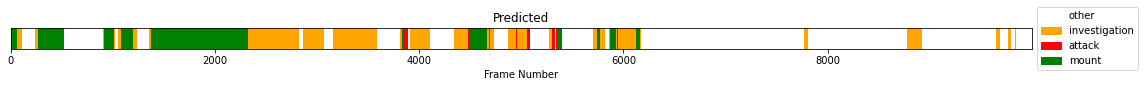

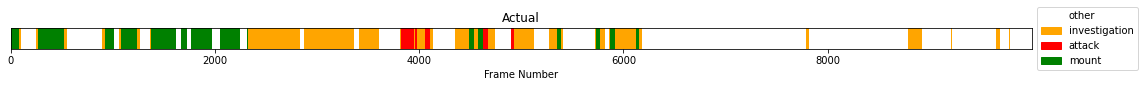

In [538]:
plot_preds(val_pred.astype(int), val_labels, 20000, 30000)

Baseline performance:

In [539]:
print(classification_report(val_labels, val_pred_probs_argmax.astype(int)))

              precision    recall  f1-score   support

           0       0.88      0.45      0.59      1830
           1       0.79      0.90      0.84     25811
           2       0.75      0.84      0.80      4488
           3       0.97      0.93      0.95     66943

    accuracy                           0.91     99072
   macro avg       0.85      0.78      0.80     99072
weighted avg       0.91      0.91      0.91     99072



In [540]:
#Confusion matrix
confusion_matrix(val_labels, val_pred.astype(int))

array([[ 1115,   610,    55,    50],
       [  239, 22765,   443,  2364],
       [   38,   648,  3765,    37],
       [   23,  3335,   399, 63186]])

In [541]:
#Plot confusion matrix
val_pred_probs

array([[7.8942778e-04, 3.7277141e-01, 5.6142598e-01, 6.5013245e-02],
       [9.6487062e-04, 3.4508190e-01, 5.8482224e-01, 6.9131032e-02],
       [5.4773525e-04, 3.5035080e-01, 5.9080935e-01, 5.8292110e-02],
       ...,
       [8.0773539e-09, 1.7915672e-03, 7.2154478e-08, 9.9820828e-01],
       [7.3577779e-09, 1.7486785e-03, 5.3961443e-08, 9.9825126e-01],
       [8.0449984e-09, 1.7924007e-03, 5.9390093e-08, 9.9820757e-01]],
      dtype=float32)

## Add a HMM.

For that we do:

In [542]:
D = val_pred_probs.shape[1]
C = 11
lambdas = np.logspace(1,30, 10)

In [543]:
hmm = fit_hmm(train_labels, train_pred_prob, train_pred, D, C)
hmm_pred = infer_hmm(hmm, val_pred_probs, val_pred)

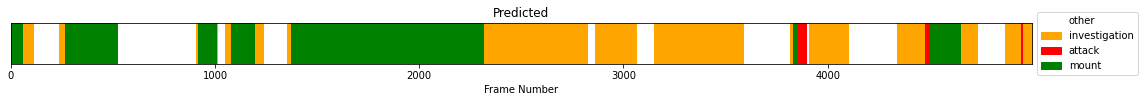

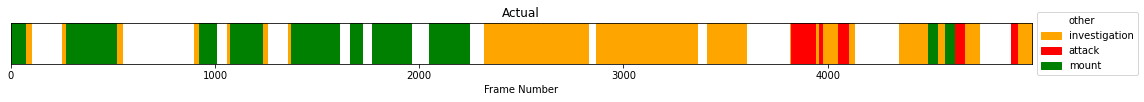

In [544]:
plot_preds(hmm_pred, val_labels, 20000, 25000)

In [545]:
print(classification_report(val_labels, hmm_pred))

              precision    recall  f1-score   support

           0       0.78      0.63      0.69      1830
           1       0.83      0.88      0.86     25811
           2       0.81      0.84      0.82      4488
           3       0.96      0.94      0.95     66943

    accuracy                           0.92     99072
   macro avg       0.85      0.82      0.83     99072
weighted avg       0.92      0.92      0.92     99072



In [546]:
print(f'f1 score (HMM): {f1_score(val_labels, hmm_pred, average = "macro", labels = [0,1,2])}')

f1 score (HMM): 0.7913253842129914


In [547]:
print(f'f1 score (before): {f1_score(val_labels, val_pred.astype(int), average = "macro", labels = [0,1,2])}')

f1 score (before): 0.7888293227729316


Thus the HMM helps squeeze extra two % from appropriate F1 score. 

In [548]:
#Once we have the HMM predictions we can format the final test data in the same way, for submission to aicrowd

## Reweighting model output to maximize F1

Here we experiment with learning optimal weights as output of network to maximize specifically the F1 score that ignores no-behavior label

In [549]:
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

In [550]:
f = lambda w: f1_score(train_labels, np.argmax((train_pred_prob*w), axis = -1), average = 'macro', labels = [0,1,2])

In [551]:
#Just do a random search....
N = 4000
w_star = np.ones(4)/4
f_star = 0

In [552]:
for idx in range(N):
    w = sample_prob_simplex()
    f_curr = f(w)
    if f_curr > f_star:
        w_star = w
        f_star = f_curr

In [553]:
f_star

0.9286929873684886

In [554]:
w_star

array([0.23249083, 0.21566807, 0.09817924, 0.45366185])

In [555]:
#Reweight and then apply HMM
val_pred_probs_reweighted = val_pred_probs*w_star
val_pred_reweighted = np.argmax(val_pred_probs_reweighted, axis = -1)

In [556]:
#Reweight and then apply HMM
train_pred_probs_reweighted = train_pred_prob*w_star
train_pred_reweighted = np.argmax(train_pred_probs_reweighted, axis = -1)

In [557]:
print(classification_report(val_labels, val_pred_reweighted))

              precision    recall  f1-score   support

           0       0.80      0.60      0.69      1830
           1       0.85      0.85      0.85     25811
           2       0.85      0.79      0.82      4488
           3       0.95      0.96      0.95     66943

    accuracy                           0.92     99072
   macro avg       0.86      0.80      0.83     99072
weighted avg       0.91      0.92      0.91     99072



In [558]:
hmm_reweighted = fit_hmm(train_labels, train_pred_probs_reweighted, train_pred_reweighted, D, C)
hmm_pred_reweighted = infer_hmm(hmm_reweighted, val_pred_probs_reweighted, val_pred_reweighted)

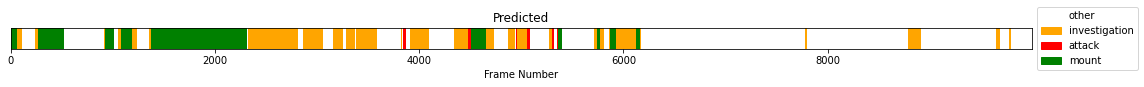

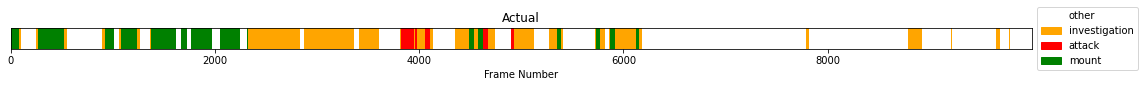

In [559]:
plot_preds(hmm_pred_reweighted, val_labels, 20000, 30000)

In [560]:
print(classification_report(val_labels, hmm_pred_reweighted))

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      1830
           1       0.85      0.85      0.85     25811
           2       0.84      0.79      0.81      4488
           3       0.95      0.96      0.95     66943

    accuracy                           0.92     99072
   macro avg       0.86      0.80      0.83     99072
weighted avg       0.91      0.92      0.91     99072



In [561]:
print(f'f1 score (reweighted HMM): {f1_score(val_labels, hmm_pred_reweighted, average = "macro", labels = [0,1,2])}')

f1 score (reweighted HMM): 0.7832089740355074


In [562]:
print(f'f1 score (reweighted): {f1_score(val_labels, val_pred_reweighted, average = "macro", labels = [0,1,2])}')

f1 score (reweighted): 0.7847330662590334


In [563]:
print(f'f1 score (before): {f1_score(val_labels, val_pred.astype(int), average = "macro", labels = [0,1,2])}')

f1 score (before): 0.7888293227729316


In [564]:
print(f'f1 score (HMM): {f1_score(val_labels, hmm_pred, average = "macro", labels = [0,1,2])}')

f1 score (HMM): 0.7913253842129914


### Submit test predictions

In [565]:
#run_name = 'lstm_full_run_bo'
#run_name = 'baseline_full_run_bo'
#run_name = 'baseline_test_run_distances_random'
run_name = 'baseline_full_run_distance_deeper_moredropout_random'
(test_pred, test_pred_probs, test_out_all_training, test_probs_out_all_training) = load_test_run(run_name, path)
test_pred = test_pred.item()
test_pred_probs = test_pred_probs.item()
test_out_all_training = test_out_all_training.item()
test_probs_out_all_training = test_probs_out_all_training.item() 

In [566]:
#Reweight and compute final prediction
final_prediction = {}

In [567]:
for k,v in test_pred_probs.items():
    final_prediction[k] = np.argmax(v*w_star, axis = -1)

In [568]:
snapshot_dir = path + run_name + '/'
np.save(snapshot_dir + 'final_reweighted_pred.npy', final_prediction)

In [569]:
#Make HMM preds
final_hmm_preds = {}
for k,v in test_pred_probs.items():
    final_hmm_preds[k] = infer_hmm(hmm, v, test_pred[k])

In [570]:
np.save(snapshot_dir + 'final_hmm_pred.npy', final_hmm_preds)

In [571]:
#Make HMM reweighted preds
final_hmm_reweighted_preds = {}
for k,v in test_pred_probs.items():
    final_hmm_reweighted_preds[k] = infer_hmm(hmm_reweighted, v, test_pred[k])

In [572]:
np.save(snapshot_dir + 'final_hmm_reweighted_pred.npy', final_hmm_reweighted_preds)

### Base on NN trained on all training data

In [573]:
#Reweight and compute final prediction
final_prediction = {}

In [574]:
for k,v in test_probs_out_all_training.items():
    final_prediction[k] = np.argmax(v*w_star, axis = -1)

In [575]:
snapshot_dir = path + run_name + '/'
np.save(snapshot_dir + 'final_reweighted_pred_all_training.npy', final_prediction)

In [576]:
#Make HMM preds
final_hmm_preds = {}
for k,v in test_probs_out_all_training.items():
    final_hmm_preds[k] = infer_hmm(hmm, v, test_out_all_training[k])

In [577]:
np.save(snapshot_dir + 'final_hmm_pred_all_training.npy', final_hmm_preds)

In [578]:
#Make HMM reweighted preds
final_hmm_reweighted_preds = {}
for k,v in test_probs_out_all_training.items():
    final_hmm_reweighted_preds[k] = infer_hmm(hmm_reweighted, v, test_out_all_training[k])

In [579]:
np.save(snapshot_dir + 'final_hmm_reweighted_pred_all_training.npy', final_hmm_reweighted_preds)

In [580]:
#Submit string:
submit_model = 'final_hmm_pred_all_training.npy'

submit_string = f'!aicrowd submission create -c mabe-task-1-classical-classification -f {snapshot_dir}/{submit_model}'
print(submit_string)

!aicrowd submission create -c mabe-task-1-classical-classification -f /home/blansdel/projects/mabe/mabetask1/snapshots/baseline_full_run_distance_deeper_moredropout_random//final_hmm_pred_all_training.npy


In [581]:
!aicrowd submission create -c mabe-task-1-classical-classification -f /home/blansdel/projects/mabe/mabetask1/snapshots/baseline_full_run_distance_deeper_moredropout_random//final_hmm_pred_all_training.npy

final_hmm_pred_all_training.npy ━━━━━━━━━ 0.0% • 0.0/65.4   • 1.7 MB/s • 0:00:400m
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.0% • 0.0/65.4   • 1.9 MB/s • 0:00:35
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.1% • 0.0/65.4   • 2.3 MB/s • 0:00:29
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.1% • 0.0/65.4   • 2.5 MB/s • 0:00:26
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.1% • 0.0/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.1% • 0.1/65.4   • 2.9 MB/s • 0:00:23
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.1% • 0.1/65.4   • 3.0 MB/s • 0:00:22
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.1% • 0.1/65.4   • 3.1 MB/s • 0:00:22
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.1% • 0.1/65.4   • 3.2 MB/s • 0:00:21
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.1% • 0.1/65.4   • 3.2 MB/s • 0:00:21
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.2% • 0.1/65.4   • 3.3 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.2% • 0.1/65.4   • 3.3 MB/s • 0:00:20
final_hmm_pred_all_trainin

final_hmm_pred_all_training.npy ━━━━━━━━━ 0.7% • 0.5/65.4   • 1.2 MB/s • 0:00:55
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.7% • 0.5/65.4   • 1.2 MB/s • 0:00:55
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.8% • 0.5/65.4   • 1.2 MB/s • 0:00:54
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.8% • 0.5/65.4   • 1.2 MB/s • 0:00:53
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.8% • 0.5/65.4   • 1.2 MB/s • 0:00:53
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.8% • 0.5/65.4   • 1.3 MB/s • 0:00:52
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.8% • 0.5/65.4   • 1.1 MB/s • 0:00:57
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.8% • 0.5/65.4   • 1.2 MB/s • 0:00:57
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.8% • 0.5/65.4   • 1.2 MB/s • 0:00:56
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.8% • 0.5/65.4   • 1.2 MB/s • 0:00:55
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.9% • 0.6/65.4   • 1.2 MB/s • 0:00:55
final_hmm_pred_all_training.npy ━━━━━━━━━ 0.9% • 0.6/65.4   • 1.2 MB/s • 0:00:54
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━━ 1.5% • 1.0/65.4   • 1.6 MB/s • 0:00:40
final_hmm_pred_all_training.npy ━━━━━━━━━ 1.5% • 1.0/65.4   • 1.6 MB/s • 0:00:41
final_hmm_pred_all_training.npy ━━━━━━━━━ 1.5% • 1.0/65.4   • 1.6 MB/s • 0:00:40
final_hmm_pred_all_training.npy ━━━━━━━━━ 1.5% • 1.0/65.4   • 1.6 MB/s • 0:00:40
final_hmm_pred_all_training.npy ━━━━━━━━━ 1.5% • 1.0/65.4   • 1.6 MB/s • 0:00:40
final_hmm_pred_all_training.npy ━━━━━━━━━ 1.5% • 1.0/65.4   • 1.6 MB/s • 0:00:40
final_hmm_pred_all_training.npy ━━━━━━━━━ 1.6% • 1.0/65.4   • 1.6 MB/s • 0:00:40
final_hmm_pred_all_training.npy ━━━━━━━━━ 1.6% • 1.0/65.4   • 1.6 MB/s • 0:00:40
final_hmm_pred_all_training.npy ━━━━━━━━━ 1.6% • 1.0/65.4   • 1.6 MB/s • 0:00:40
final_hmm_pred_all_training.npy ━━━━━━━━━ 1.6% • 1.0/65.4   • 1.7 MB/s • 0:00:39
final_hmm_pred_all_training.npy ━━━━━━━━━ 1.6% • 1.0/65.4   • 1.7 MB/s • 0:00:39
final_hmm_pred_all_training.npy ━━━━━━━━━ 1.6% • 1.1/65.4   • 1.7 MB/s • 0:00:39
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━━ 2.3% • 1.5/65.4   • 2.0 MB/s • 0:00:33
final_hmm_pred_all_training.npy ━━━━━━━━━ 2.3% • 1.5/65.4   • 2.0 MB/s • 0:00:33
final_hmm_pred_all_training.npy ━━━━━━━━━ 2.3% • 1.5/65.4   • 2.0 MB/s • 0:00:33
final_hmm_pred_all_training.npy ━━━━━━━━━ 2.3% • 1.5/65.4   • 2.0 MB/s • 0:00:33
final_hmm_pred_all_training.npy ━━━━━━━━━ 2.3% • 1.5/65.4   • 2.0 MB/s • 0:00:32
final_hmm_pred_all_training.npy ━━━━━━━━━ 2.3% • 1.5/65.4   • 2.0 MB/s • 0:00:32
final_hmm_pred_all_training.npy ━━━━━━━━━ 2.4% • 1.5/65.4   • 2.0 MB/s • 0:00:32
final_hmm_pred_all_training.npy ━━━━━━━━━ 2.4% • 1.5/65.4   • 2.0 MB/s • 0:00:32
final_hmm_pred_all_training.npy ━━━━━━━━━ 2.4% • 1.6/65.4   • 2.0 MB/s • 0:00:32
final_hmm_pred_all_training.npy ━━━━━━━━━ 2.4% • 1.6/65.4   • 2.0 MB/s • 0:00:32
final_hmm_pred_all_training.npy ━━━━━━━━━ 2.4% • 1.6/65.4   • 2.0 MB/s • 0:00:32
final_hmm_pred_all_training.npy ━━━━━━━━━ 2.4% • 1.6/65.4   • 2.0 MB/s • 0:00:32
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━━ 3.1% • 2.0/65.4   • 2.3 MB/s • 0:00:29
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.1% • 2.0/65.4   • 2.3 MB/s • 0:00:29
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.1% • 2.1/65.4   • 2.3 MB/s • 0:00:29
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.2% • 2.1/65.4   • 2.3 MB/s • 0:00:28
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.2% • 2.1/65.4   • 2.3 MB/s • 0:00:28
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.2% • 2.1/65.4   • 2.3 MB/s • 0:00:28
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.2% • 2.1/65.4   • 2.3 MB/s • 0:00:29
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.2% • 2.1/65.4   • 2.3 MB/s • 0:00:29
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.2% • 2.1/65.4   • 2.3 MB/s • 0:00:28
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.2% • 2.1/65.4   • 2.3 MB/s • 0:00:28
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.2% • 2.1/65.4   • 2.3 MB/s • 0:00:28
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.2% • 2.1/65.4   • 2.3 MB/s • 0:00:28
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━━ 3.9% • 2.5/65.4   • 2.4 MB/s • 0:00:27
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.9% • 2.6/65.4   • 2.4 MB/s • 0:00:27
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.9% • 2.6/65.4   • 2.4 MB/s • 0:00:27
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.9% • 2.6/65.4   • 2.4 MB/s • 0:00:26
final_hmm_pred_all_training.npy ━━━━━━━━━ 3.9% • 2.6/65.4   • 2.4 MB/s • 0:00:26
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.0% • 2.6/65.4   • 2.4 MB/s • 0:00:26
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.0% • 2.6/65.4   • 2.4 MB/s • 0:00:26
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.0% • 2.6/65.4   • 2.4 MB/s • 0:00:26
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.0% • 2.6/65.4   • 2.4 MB/s • 0:00:26
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.0% • 2.6/65.4   • 2.4 MB/s • 0:00:26
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.0% • 2.6/65.4   • 2.4 MB/s • 0:00:26
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.0% • 2.6/65.4   • 2.4 MB/s • 0:00:26
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━━ 4.7% • 3.1/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.7% • 3.1/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.8% • 3.1/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.8% • 3.1/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.8% • 3.1/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.8% • 3.1/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.8% • 3.1/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.8% • 3.2/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.8% • 3.2/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.8% • 3.2/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.9% • 3.2/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.npy ━━━━━━━━━ 4.9% • 3.2/65.4   • 2.6 MB/s • 0:00:25
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━━ 5.5% • 3.6/65.4   • 2.6 MB/s • 0:00:24
final_hmm_pred_all_training.npy ━━━━━━━━━ 5.5% • 3.6/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.npy ━━━━━━━━━ 5.6% • 3.6/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.npy ╸━━━━━━━━ 5.6% • 3.6/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.npy ╸━━━━━━━━ 5.6% • 3.6/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.npy ╸━━━━━━━━ 5.6% • 3.7/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.npy ╸━━━━━━━━ 5.6% • 3.7/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.npy ╸━━━━━━━━ 5.6% • 3.7/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.npy ╸━━━━━━━━ 5.6% • 3.7/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.npy ╸━━━━━━━━ 5.6% • 3.7/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.npy ╸━━━━━━━━ 5.7% • 3.7/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.npy ╸━━━━━━━━ 5.7% • 3.7/65.4   • 2.7 MB/s • 0:00:24
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.3% • 4.1/65.4   • 2.7 MB/s • 0:00:23
final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.4% • 4.2/65.4   • 2.7 MB/s • 0:00:23
final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.4% • 4.2/65.4   • 2.7 MB/s • 0:00:23
final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.4% • 4.2/65.4   • 2.7 MB/s • 0:00:23
final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.4% • 4.2/65.4   • 2.7 MB/s • 0:00:23
final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.4% • 4.2/65.4   • 2.7 MB/s • 0:00:23
final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.4% • 4.2/65.4   • 2.7 MB/s • 0:00:23
final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.4% • 4.2/65.4   • 2.7 MB/s • 0:00:23
final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.4% • 4.2/65.4   • 2.7 MB/s • 0:00:23
final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.5% • 4.2/65.4   • 2.7 MB/s • 0:00:23
final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.5% • 4.2/65.4   • 2.7 MB/s • 0:00:23
final_hmm_pred_all_training.npy ╸━━━━━━━━ 6.5% • 4.2/65.4   • 2.8 MB/s • 0:00:23
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.1% • 4.7/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.1% • 4.7/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.2% • 4.7/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.2% • 4.7/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.2% • 4.7/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.2% • 4.7/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.2% • 4.7/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.2% • 4.7/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.2% • 4.7/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.2% • 4.7/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.3% • 4.7/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.3% • 4.8/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.9% • 5.2/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.9% • 5.2/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 7.9% • 5.2/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.0% • 5.2/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.0% • 5.2/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.0% • 5.2/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.0% • 5.2/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.0% • 5.2/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.0% • 5.2/65.4   • 2.8 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.0% • 5.3/65.4   • 2.9 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.0% • 5.3/65.4   • 2.9 MB/s • 0:00:22
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.1% • 5.3/65.4   • 2.9 MB/s • 0:00:22
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.7% • 5.7/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.7% • 5.7/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.7% • 5.7/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.8% • 5.7/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.8% • 5.7/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.8% • 5.7/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.8% • 5.8/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.8% • 5.8/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.8% • 5.8/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.8% • 5.8/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.8% • 5.8/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 8.9% • 5.8/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.5% • 6.2/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.5% • 6.2/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.5% • 6.2/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.5% • 6.2/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.5% • 6.2/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.5% • 6.2/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.6% • 6.3/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.6% • 6.3/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.6% • 6.3/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.6% • 6.3/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.6% • 6.3/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.npy ╸━━━━━━━━ 9.6% • 6.3/65.4   • 2.9 MB/s • 0:00:21
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.3% • 6.7/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.3% • 6.7/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.3% • 6.7/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.3% • 6.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.3% • 6.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.3% • 6.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.4% • 6.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.4% • 6.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.4% • 6.8/65.4  • 2.9 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.4% • 6.8/65.4  • 2.9 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.4% • 6.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 10.4% • 6.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ╸━━━━━━━━ 11.0% • 7.2/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 11.0% • 7.2/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 11.1% • 7.2/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 11.1% • 7.2/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 11.1% • 7.2/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 11.1% • 7.2/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ╸━━━━━━━━ 11.1% • 7.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.1% • 7.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.1% • 7.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.1% • 7.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.2% • 7.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.2% • 7.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.8% • 7.7/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.9% • 7.7/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.9% • 7.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.9% • 7.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.9% • 7.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.9% • 7.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.9% • 7.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.9% • 7.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 11.9% • 7.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.0% • 7.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.0% • 7.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.0% • 7.8/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.6% • 8.2/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.6% • 8.2/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.6% • 8.2/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.6% • 8.2/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.6% • 8.2/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.6% • 8.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.6% • 8.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.7% • 8.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.7% • 8.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.7% • 8.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.7% • 8.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.npy ━╺━━━━━━━ 12.7% • 8.3/65.4  • 3.0 MB/s • 0:00:20
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.4% • 8.7/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.4% • 8.7/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.4% • 8.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.4% • 8.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.4% • 8.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.4% • 8.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.4% • 8.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.5% • 8.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.5% • 8.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.5% • 8.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.5% • 8.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 13.5% • 8.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.1% • 9.2/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.1% • 9.2/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.2% • 9.3/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.2% • 9.3/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.2% • 9.3/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.2% • 9.3/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.2% • 9.3/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.2% • 9.3/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.2% • 9.3/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.2% • 9.3/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.3% • 9.3/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.3% • 9.3/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.9% • 9.7/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.9% • 9.7/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.9% • 9.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.9% • 9.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 14.9% • 9.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.0% • 9.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.0% • 9.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.0% • 9.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.0% • 9.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.0% • 9.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.0% • 9.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.0% • 9.8/65.4  • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.7% • 10.2/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.7% • 10.3/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.7% • 10.3/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.7% • 10.3/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.7% • 10.3/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.7% • 10.3/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.7% • 10.3/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.7% • 10.3/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.8% • 10.3/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.8% • 10.3/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.8% • 10.3/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 15.8% • 10.3/65.4 • 3.4 MB/s • 0:00:17
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.4% • 10.7/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.4% • 10.7/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.4% • 10.7/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.4% • 10.7/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.5% • 10.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.5% • 10.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.5% • 10.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.5% • 10.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.5% • 10.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.5% • 10.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.5% • 10.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╺━━━━━━━ 16.5% • 10.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.2% • 11.2/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.2% • 11.2/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.2% • 11.2/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.2% • 11.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.2% • 11.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.2% • 11.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.3% • 11.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.3% • 11.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.3% • 11.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.3% • 11.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.3% • 11.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.3% • 11.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.9% • 11.7/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.9% • 11.7/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.9% • 11.7/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 17.9% • 11.7/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.0% • 11.7/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.0% • 11.7/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.0% • 11.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.0% • 11.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.0% • 11.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.0% • 11.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.0% • 11.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.0% • 11.8/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.7% • 12.2/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.7% • 12.2/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.7% • 12.2/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.7% • 12.2/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.7% • 12.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.8% • 12.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.8% • 12.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.8% • 12.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.8% • 12.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.8% • 12.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.8% • 12.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.npy ━╸━━━━━━━ 18.8% • 12.3/65.4 • 3.3 MB/s • 0:00:17
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.5% • 12.7/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.5% • 12.7/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.5% • 12.7/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.5% • 12.7/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.5% • 12.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.5% • 12.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.5% • 12.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.5% • 12.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.6% • 12.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.6% • 12.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.6% • 12.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 19.6% • 12.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.2% • 13.2/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.2% • 13.2/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.3% • 13.2/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.3% • 13.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.3% • 13.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.3% • 13.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.3% • 13.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.3% • 13.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.3% • 13.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.3% • 13.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.4% • 13.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 20.4% • 13.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.0% • 13.7/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.0% • 13.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.0% • 13.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.0% • 13.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.1% • 13.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.1% • 13.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.1% • 13.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.1% • 13.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.1% • 13.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.1% • 13.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.1% • 13.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.1% • 13.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.8% • 14.2/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.8% • 14.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.8% • 14.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.8% • 14.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.8% • 14.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.9% • 14.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.9% • 14.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.9% • 14.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.9% • 14.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.9% • 14.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.9% • 14.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━╸━━━━━━━ 21.9% • 14.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.6% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.6% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.6% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.6% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.6% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.6% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.6% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.7% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.7% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.7% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.7% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 22.7% • 14.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.3% • 15.2/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.3% • 15.2/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.3% • 15.2/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.3% • 15.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.3% • 15.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.4% • 15.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.4% • 15.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.4% • 15.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.4% • 15.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.4% • 15.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.4% • 15.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 23.4% • 15.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.1% • 15.7/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.1% • 15.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.1% • 15.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.1% • 15.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.1% • 15.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.1% • 15.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.2% • 15.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.2% • 15.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.2% • 15.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.2% • 15.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.2% • 15.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.2% • 15.8/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.8% • 16.2/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.8% • 16.2/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.8% • 16.2/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.8% • 16.2/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.9% • 16.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.9% • 16.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.9% • 16.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.9% • 16.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.9% • 16.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.9% • 16.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.9% • 16.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.npy ━━╺━━━━━━ 24.9% • 16.3/65.4 • 3.3 MB/s • 0:00:16
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.6% • 16.7/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.6% • 16.7/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.6% • 16.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.6% • 16.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.6% • 16.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.7% • 16.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.7% • 16.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.7% • 16.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.7% • 16.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.7% • 16.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.7% • 16.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 25.7% • 16.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.4% • 17.2/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.4% • 17.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.4% • 17.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.4% • 17.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.4% • 17.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.4% • 17.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.4% • 17.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.5% • 17.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.5% • 17.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.5% • 17.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.5% • 17.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 26.5% • 17.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.1% • 17.7/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.1% • 17.7/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.1% • 17.7/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.2% • 17.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.2% • 17.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.2% • 17.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.2% • 17.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.2% • 17.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.2% • 17.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.2% • 17.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.2% • 17.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╺━━━━━━ 27.3% • 17.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╸━━━━━━ 27.9% • 18.2/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 27.9% • 18.2/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 27.9% • 18.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 27.9% • 18.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 27.9% • 18.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.0% • 18.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.0% • 18.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.0% • 18.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.0% • 18.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.0% • 18.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.0% • 18.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.0% • 18.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.6% • 18.7/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.6% • 18.7/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.6% • 18.7/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.7% • 18.7/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.7% • 18.7/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.7% • 18.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.7% • 18.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.7% • 18.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.7% • 18.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.7% • 18.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.7% • 18.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 28.8% • 18.8/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.4% • 19.2/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.4% • 19.2/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.4% • 19.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.5% • 19.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.5% • 19.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.5% • 19.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.5% • 19.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.5% • 19.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.5% • 19.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.5% • 19.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.5% • 19.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.npy ━━╸━━━━━━ 29.5% • 19.3/65.4 • 3.3 MB/s • 0:00:15
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.1% • 19.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.2% • 19.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.2% • 19.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.2% • 19.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.2% • 19.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.2% • 19.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.2% • 19.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.2% • 19.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.2% • 19.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.3% • 19.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.3% • 19.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.3% • 19.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.9% • 20.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 30.9% • 20.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.0% • 20.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.0% • 20.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.0% • 20.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.0% • 20.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.0% • 20.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.0% • 20.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.0% • 20.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.0% • 20.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.1% • 20.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.1% • 20.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.7% • 20.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.7% • 20.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.7% • 20.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.7% • 20.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.7% • 20.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.7% • 20.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.7% • 20.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.7% • 20.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.8% • 20.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.8% • 20.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.8% • 20.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 31.8% • 20.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.4% • 21.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.4% • 21.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.5% • 21.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.5% • 21.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.5% • 21.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.5% • 21.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.5% • 21.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.5% • 21.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.5% • 21.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.5% • 21.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.6% • 21.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 32.6% • 21.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.2% • 21.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.2% • 21.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.2% • 21.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.2% • 21.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.2% • 21.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.3% • 21.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.3% • 21.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.3% • 21.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.3% • 21.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.3% • 21.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.3% • 21.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━╸━━━━━━ 33.3% • 21.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╺━━━━━ 33.9% • 22.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.0% • 22.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.0% • 22.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.0% • 22.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.0% • 22.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.0% • 22.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.0% • 22.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.0% • 22.2/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.0% • 22.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.1% • 22.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.1% • 22.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.1% • 22.3/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.7% • 22.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.8% • 22.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.8% • 22.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.8% • 22.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.8% • 22.7/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.8% • 22.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.8% • 22.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.8% • 22.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.8% • 22.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.8% • 22.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.9% • 22.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.npy ━━━╺━━━━━ 34.9% • 22.8/65.4 • 3.3 MB/s • 0:00:14
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.5% • 23.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.5% • 23.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.5% • 23.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.5% • 23.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.5% • 23.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.5% • 23.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.5% • 23.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.6% • 23.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.6% • 23.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.6% • 23.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.6% • 23.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 35.6% • 23.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.2% • 23.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.2% • 23.7/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.3% • 23.7/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.3% • 23.7/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.3% • 23.7/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.3% • 23.7/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.3% • 23.7/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.3% • 23.7/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.3% • 23.8/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.3% • 23.8/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.4% • 23.8/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 36.4% • 23.8/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.0% • 24.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.0% • 24.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.0% • 24.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.0% • 24.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.0% • 24.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.0% • 24.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.0% • 24.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.1% • 24.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.1% • 24.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.1% • 24.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.1% • 24.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.1% • 24.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.8% • 24.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.8% • 24.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.8% • 24.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.8% • 24.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.8% • 24.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.8% • 24.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.8% • 24.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.8% • 24.7/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.9% • 24.7/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.9% • 24.8/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.9% • 24.8/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 37.9% • 24.8/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.5% • 25.2/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.5% • 25.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.5% • 25.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.6% • 25.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.6% • 25.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.6% • 25.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.6% • 25.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.6% • 25.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.6% • 25.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.6% • 25.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.6% • 25.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╺━━━━━ 38.7% • 25.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.3% • 25.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.3% • 25.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.3% • 25.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.3% • 25.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.3% • 25.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.3% • 25.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.3% • 25.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.4% • 25.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.4% • 25.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.4% • 25.7/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.4% • 25.8/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 39.4% • 25.8/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.1% • 26.2/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.1% • 26.2/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.1% • 26.2/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.1% • 26.2/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.1% • 26.2/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.1% • 26.2/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.1% • 26.2/65.4 • 3.3 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.1% • 26.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.1% • 26.2/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.2% • 26.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.2% • 26.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.2% • 26.3/65.4 • 3.2 MB/s • 0:00:13
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.8% • 26.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.8% • 26.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.8% • 26.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.8% • 26.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.8% • 26.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.9% • 26.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.9% • 26.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.9% • 26.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.9% • 26.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.9% • 26.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.9% • 26.8/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 40.9% • 26.8/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.6% • 27.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.6% • 27.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.6% • 27.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.6% • 27.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.6% • 27.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.6% • 27.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.6% • 27.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.7% • 27.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.7% • 27.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.7% • 27.3/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.7% • 27.3/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 41.7% • 27.3/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.3% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.3% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.3% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.3% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.3% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.4% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.4% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.4% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.4% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.4% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.4% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 42.4% • 27.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.1% • 28.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.1% • 28.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.1% • 28.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.1% • 28.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.1% • 28.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.2% • 28.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.2% • 28.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.2% • 28.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.2% • 28.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.2% • 28.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.2% • 28.3/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.2% • 28.3/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.8% • 28.7/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.8% • 28.7/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.9% • 28.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.9% • 28.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.9% • 28.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.9% • 28.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.9% • 28.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.9% • 28.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.9% • 28.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 43.9% • 28.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 44.0% • 28.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━╸━━━━━ 44.0% • 28.7/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.6% • 29.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.6% • 29.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.6% • 29.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.6% • 29.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.6% • 29.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.7% • 29.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.7% • 29.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.7% • 29.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.7% • 29.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.7% • 29.2/65.4 • 3.2 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.7% • 29.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.npy ━━━━╺━━━━ 44.7% • 29.2/65.4 • 3.3 MB/s • 0:00:12
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.4% • 29.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.4% • 29.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.4% • 29.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.4% • 29.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.4% • 29.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.4% • 29.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.5% • 29.7/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.5% • 29.7/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.5% • 29.7/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.5% • 29.7/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.5% • 29.8/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 45.5% • 29.8/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.1% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.1% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.1% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.2% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.2% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.2% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.2% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.2% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.2% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.2% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.2% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.3% • 30.2/65.4 • 3.2 MB/s • 0:00:11
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.9% • 30.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.9% • 30.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.9% • 30.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 46.9% • 30.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.0% • 30.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.0% • 30.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.0% • 30.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.0% • 30.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.0% • 30.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.0% • 30.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.0% • 30.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.0% • 30.8/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.6% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.7% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.7% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.7% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.7% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.7% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.7% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.7% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.7% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.8% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.8% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 47.8% • 31.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.4% • 31.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.5% • 31.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.5% • 31.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.5% • 31.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.5% • 31.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.5% • 31.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.5% • 31.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.5% • 31.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.5% • 31.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.6% • 31.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.6% • 31.8/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 48.6% • 31.8/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.2% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.2% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.2% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.2% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.2% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.2% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.3% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.3% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.3% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.3% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.3% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 49.3% • 32.2/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╺━━━━ 50.0% • 32.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 50.0% • 32.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 50.0% • 32.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╺━━━━ 50.0% • 32.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.0% • 32.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.0% • 32.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.0% • 32.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.0% • 32.7/65.4 • 3.3 MB/s • 0:00:11
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.1% • 32.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.1% • 32.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.1% • 32.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.1% • 32.8/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.7% • 33.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.7% • 33.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.7% • 33.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.8% • 33.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.8% • 33.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.8% • 33.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.8% • 33.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.8% • 33.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.8% • 33.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.8% • 33.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.8% • 33.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 50.9% • 33.3/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.4% • 33.6/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.5% • 33.6/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.5% • 33.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.5% • 33.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.5% • 33.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.5% • 33.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.5% • 33.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.5% • 33.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.5% • 33.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.6% • 33.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.6% • 33.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 51.6% • 33.7/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.2% • 34.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.2% • 34.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.3% • 34.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.3% • 34.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.3% • 34.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.3% • 34.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.3% • 34.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.3% • 34.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.3% • 34.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.3% • 34.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.3% • 34.2/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.4% • 34.2/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╸━━━━ 52.9% • 34.6/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.0% • 34.6/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.0% • 34.6/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.0% • 34.6/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.0% • 34.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.0% • 34.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.0% • 34.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.0% • 34.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.0% • 34.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.1% • 34.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.1% • 34.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.1% • 34.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.7% • 35.1/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.8% • 35.1/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.8% • 35.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.8% • 35.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.8% • 35.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.8% • 35.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.8% • 35.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.8% • 35.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.8% • 35.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.9% • 35.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.9% • 35.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 53.9% • 35.2/65.4 • 3.3 MB/s • 0:00:10
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.5% • 35.6/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.5% • 35.6/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.5% • 35.6/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.5% • 35.6/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.5% • 35.6/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.5% • 35.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.5% • 35.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.6% • 35.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.6% • 35.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.6% • 35.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.6% • 35.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 54.6% • 35.7/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.2% • 36.1/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.3% • 36.1/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.3% • 36.1/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.3% • 36.1/65.4 • 3.2 MB/s • 0:00:10
final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.3% • 36.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.3% • 36.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.3% • 36.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.3% • 36.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.3% • 36.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.4% • 36.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.4% • 36.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━╸━━━━ 55.4% • 36.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.0% • 36.6/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.0% • 36.6/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.0% • 36.6/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.0% • 36.6/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.1% • 36.7/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.1% • 36.7/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.1% • 36.7/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.1% • 36.7/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.1% • 36.7/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.1% • 36.7/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.1% • 36.7/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.1% • 36.7/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.8% • 37.1/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.8% • 37.1/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.8% • 37.1/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.8% • 37.1/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.8% • 37.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.8% • 37.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.8% • 37.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.9% • 37.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.9% • 37.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.9% • 37.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.9% • 37.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 56.9% • 37.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.6% • 37.6/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.6% • 37.6/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.6% • 37.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.6% • 37.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.6% • 37.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.6% • 37.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.6% • 37.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.6% • 37.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.6% • 37.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.7% • 37.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.7% • 37.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 57.7% • 37.7/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.3% • 38.1/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.3% • 38.1/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.3% • 38.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.4% • 38.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.4% • 38.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.4% • 38.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.4% • 38.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.4% • 38.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.4% • 38.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.4% • 38.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.4% • 38.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 58.5% • 38.2/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.1% • 38.6/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.1% • 38.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.1% • 38.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.2% • 38.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.2% • 38.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.2% • 38.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.2% • 38.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.2% • 38.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.2% • 38.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.2% • 38.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.2% • 38.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.2% • 38.7/65.4 • 3.3 MB/s • 0:00:09
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.8% • 39.1/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.8% • 39.1/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.9% • 39.1/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.9% • 39.1/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.9% • 39.1/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.9% • 39.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.9% • 39.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.9% • 39.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.9% • 39.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 59.9% • 39.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.0% • 39.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.0% • 39.2/65.4 • 3.2 MB/s • 0:00:09
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.6% • 39.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.6% • 39.6/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.6% • 39.6/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.6% • 39.6/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.7% • 39.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.7% • 39.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.7% • 39.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.7% • 39.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.7% • 39.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.7% • 39.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.7% • 39.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╺━━━ 60.7% • 39.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.4% • 40.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.4% • 40.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.4% • 40.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.4% • 40.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.4% • 40.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.4% • 40.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.4% • 40.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.5% • 40.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.5% • 40.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.5% • 40.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.5% • 40.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 61.5% • 40.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.1% • 40.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.1% • 40.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.1% • 40.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.2% • 40.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.2% • 40.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.2% • 40.7/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.2% • 40.7/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.2% • 40.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.2% • 40.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.2% • 40.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.2% • 40.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.3% • 40.7/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.9% • 41.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.9% • 41.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.9% • 41.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 62.9% • 41.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.0% • 41.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.0% • 41.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.0% • 41.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.0% • 41.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.0% • 41.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.0% • 41.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.0% • 41.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.0% • 41.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.6% • 41.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.6% • 41.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.6% • 41.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.7% • 41.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.7% • 41.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.7% • 41.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.7% • 41.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.7% • 41.7/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.7% • 41.7/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.7% • 41.7/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.7% • 41.7/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 63.8% • 41.7/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.4% • 42.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.4% • 42.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.4% • 42.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.4% • 42.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.4% • 42.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.5% • 42.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.5% • 42.1/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.5% • 42.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.5% • 42.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.5% • 42.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.5% • 42.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 64.5% • 42.2/65.4 • 3.3 MB/s • 0:00:08
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.1% • 42.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.1% • 42.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.1% • 42.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.1% • 42.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.2% • 42.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.2% • 42.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.2% • 42.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.2% • 42.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.2% • 42.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.2% • 42.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.2% • 42.6/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.2% • 42.7/65.4 • 3.2 MB/s • 0:00:08
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.9% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.9% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.9% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.9% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.9% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.9% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.9% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 65.9% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.0% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.0% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.0% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.0% • 43.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.5% • 43.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.5% • 43.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.6% • 43.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.6% • 43.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.6% • 43.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.6% • 43.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.6% • 43.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.6% • 43.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.6% • 43.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.6% • 43.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━╸━━━ 66.7% • 43.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 66.7% • 43.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.3% • 44.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.3% • 44.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.3% • 44.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.3% • 44.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.3% • 44.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.3% • 44.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.4% • 44.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.4% • 44.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.4% • 44.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.4% • 44.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.4% • 44.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 67.4% • 44.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.1% • 44.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.1% • 44.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.1% • 44.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.1% • 44.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.1% • 44.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.1% • 44.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.1% • 44.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.1% • 44.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.2% • 44.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.2% • 44.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.2% • 44.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.2% • 44.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.8% • 45.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.8% • 45.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.8% • 45.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.8% • 45.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.8% • 45.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.9% • 45.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.9% • 45.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.9% • 45.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.9% • 45.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.9% • 45.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.9% • 45.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 68.9% • 45.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.6% • 45.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.6% • 45.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.6% • 45.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.6% • 45.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.6% • 45.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.6% • 45.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.6% • 45.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.7% • 45.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.7% • 45.5/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.7% • 45.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.7% • 45.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 69.7% • 45.6/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.3% • 46.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.3% • 46.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.3% • 46.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.3% • 46.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.4% • 46.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.4% • 46.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.4% • 46.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.4% • 46.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.4% • 46.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.4% • 46.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.4% • 46.0/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.npy ━━━━━━╺━━ 70.4% • 46.1/65.4 • 3.2 MB/s • 0:00:07
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.1% • 46.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.1% • 46.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.1% • 46.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.1% • 46.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.1% • 46.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.2% • 46.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.2% • 46.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.2% • 46.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.2% • 46.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.2% • 46.6/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.2% • 46.6/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.2% • 46.6/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.8% • 46.9/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.8% • 47.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.8% • 47.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.8% • 47.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.9% • 47.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.9% • 47.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.9% • 47.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.9% • 47.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.9% • 47.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.9% • 47.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.9% • 47.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╺━━ 71.9% • 47.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.6% • 47.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.6% • 47.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.6% • 47.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.6% • 47.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.6% • 47.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.7% • 47.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.7% • 47.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.7% • 47.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.7% • 47.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.7% • 47.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.7% • 47.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 72.7% • 47.6/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.3% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.4% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.4% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.4% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.4% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.4% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.4% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.4% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.4% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.5% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.5% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 73.5% • 48.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.1% • 48.4/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.1% • 48.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.1% • 48.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.1% • 48.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.1% • 48.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.2% • 48.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.2% • 48.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.2% • 48.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.2% • 48.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.2% • 48.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.2% • 48.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.2% • 48.5/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.9% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.9% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.9% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.9% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.9% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.9% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.9% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 74.9% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.0% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.0% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.0% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.0% • 49.0/65.4 • 3.2 MB/s • 0:00:06
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.6% • 49.4/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.6% • 49.4/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.6% • 49.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.7% • 49.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.7% • 49.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.7% • 49.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.7% • 49.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.7% • 49.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.7% • 49.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.7% • 49.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.7% • 49.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 75.8% • 49.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.4% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.4% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.4% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.4% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.5% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.5% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.5% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.5% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.5% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.5% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.5% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 76.5% • 50.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.1% • 50.4/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.1% • 50.4/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.2% • 50.4/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.2% • 50.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.2% • 50.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.2% • 50.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.2% • 50.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.2% • 50.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.2% • 50.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.2% • 50.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.3% • 50.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━╸━━ 77.3% • 50.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╺━ 77.9% • 50.9/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 77.9% • 50.9/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 77.9% • 51.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 77.9% • 51.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.0% • 51.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.0% • 51.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.0% • 51.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.0% • 51.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.0% • 51.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.0% • 51.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.0% • 51.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.0% • 51.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.6% • 51.4/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.7% • 51.4/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.7% • 51.4/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.7% • 51.4/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.7% • 51.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.7% • 51.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.7% • 51.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.7% • 51.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.7% • 51.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.8% • 51.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.8% • 51.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 78.8% • 51.5/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.4% • 51.9/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.4% • 51.9/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.4% • 51.9/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.4% • 51.9/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.5% • 52.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.5% • 52.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.5% • 52.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.5% • 52.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.5% • 52.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.5% • 52.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.5% • 52.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.npy ━━━━━━━╺━ 79.5% • 52.0/65.4 • 3.2 MB/s • 0:00:05
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.2% • 52.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.2% • 52.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.2% • 52.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.2% • 52.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.2% • 52.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.2% • 52.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.3% • 52.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.3% • 52.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.3% • 52.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.3% • 52.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.3% • 52.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.3% • 52.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.9% • 52.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 80.9% • 52.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.0% • 52.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.0% • 52.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.0% • 52.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.0% • 53.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.0% • 53.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.0% • 53.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.0% • 53.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.0% • 53.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.1% • 53.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.1% • 53.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.7% • 53.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.7% • 53.4/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.7% • 53.4/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.8% • 53.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.8% • 53.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.8% • 53.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.8% • 53.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.8% • 53.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.8% • 53.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.8% • 53.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.8% • 53.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 81.8% • 53.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.4% • 53.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.5% • 53.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.5% • 53.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.5% • 53.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.5% • 53.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.5% • 53.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.5% • 54.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.5% • 54.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.5% • 54.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.6% • 54.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.6% • 54.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 82.6% • 54.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╺━ 83.2% • 54.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 83.2% • 54.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 83.3% • 54.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 83.3% • 54.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 83.3% • 54.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 83.3% • 54.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 83.3% • 54.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 83.3% • 54.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╺━ 83.3% • 54.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 83.3% • 54.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 83.3% • 54.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 83.4% • 54.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.0% • 54.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.0% • 54.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.0% • 54.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.0% • 54.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.0% • 54.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.0% • 54.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.0% • 54.9/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.0% • 55.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.1% • 55.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.1% • 55.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.1% • 55.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.1% • 55.0/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.7% • 55.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.7% • 55.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.8% • 55.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.8% • 55.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.8% • 55.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.8% • 55.4/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.8% • 55.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.8% • 55.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.8% • 55.5/65.4 • 3.2 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.8% • 55.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.9% • 55.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.npy ━━━━━━━╸━ 84.9% • 55.5/65.4 • 3.3 MB/s • 0:00:04
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.5% • 55.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.5% • 55.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.5% • 55.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.5% • 55.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.5% • 55.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.5% • 55.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.5% • 55.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.6% • 55.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.6% • 56.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.6% • 56.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.6% • 56.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 85.6% • 56.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.2% • 56.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.3% • 56.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.3% • 56.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.3% • 56.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.3% • 56.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.3% • 56.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.3% • 56.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.3% • 56.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.3% • 56.5/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.4% • 56.5/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.4% • 56.5/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 86.4% • 56.5/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.0% • 56.9/65.4 • 3.3 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.0% • 56.9/65.4 • 3.3 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.0% • 56.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.1% • 56.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.1% • 56.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.1% • 56.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.1% • 56.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.1% • 57.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.1% • 57.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.1% • 57.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.1% • 57.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.2% • 57.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.8% • 57.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.8% • 57.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.8% • 57.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.8% • 57.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.8% • 57.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.8% • 57.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.8% • 57.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.8% • 57.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.9% • 57.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.9% • 57.5/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.9% • 57.5/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 87.9% • 57.5/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.5% • 57.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.6% • 57.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.6% • 57.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.6% • 57.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.6% • 57.9/65.4 • 3.3 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.6% • 57.9/65.4 • 3.3 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.6% • 57.9/65.4 • 3.3 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.6% • 57.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.6% • 58.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.6% • 58.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.7% • 58.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━╸━ 88.7% • 58.0/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.3% • 58.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.3% • 58.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.3% • 58.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.3% • 58.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.3% • 58.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.3% • 58.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.3% • 58.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.4% • 58.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.4% • 58.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.4% • 58.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.4% • 58.4/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 89.4% • 58.5/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.1% • 58.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.1% • 58.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.1% • 58.9/65.4 • 3.2 MB/s • 0:00:03
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.1% • 58.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.1% • 58.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.1% • 58.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.1% • 58.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.1% • 58.9/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.2% • 58.9/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.2% • 59.0/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.2% • 59.0/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.2% • 59.0/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.8% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.8% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.8% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.8% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.8% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.8% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.9% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.9% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.9% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.9% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.9% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 90.9% • 59.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.6% • 59.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.6% • 59.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.6% • 59.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.6% • 59.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.6% • 59.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.6% • 59.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.7% • 59.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.7% • 59.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.7% • 59.9/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.7% • 59.9/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.7% • 60.0/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 91.7% • 60.0/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.3% • 60.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.4% • 60.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.4% • 60.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.4% • 60.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.4% • 60.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.4% • 60.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.4% • 60.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.4% • 60.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.4% • 60.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.5% • 60.4/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.5% • 60.5/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 92.5% • 60.5/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.1% • 60.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.1% • 60.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.1% • 60.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.1% • 60.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.2% • 60.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.2% • 60.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.2% • 60.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.2% • 60.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.2% • 60.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.2% • 60.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.2% • 61.0/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.2% • 61.0/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.9% • 61.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.9% • 61.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.9% • 61.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.9% • 61.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.9% • 61.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 93.9% • 61.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 94.0% • 61.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 94.0% • 61.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 94.0% • 61.4/65.4 • 3.3 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 94.0% • 61.5/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 94.0% • 61.5/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╺ 94.0% • 61.5/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.6% • 61.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.6% • 61.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.7% • 61.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.7% • 61.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.7% • 61.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.7% • 61.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.7% • 61.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.7% • 61.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.7% • 61.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.7% • 61.9/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.8% • 62.0/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.npy ━━━━━━━━╸ 94.8% • 62.0/65.4 • 3.2 MB/s • 0:00:02
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.4% • 62.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.4% • 62.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.5% • 62.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.5% • 62.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.5% • 62.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.5% • 62.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.5% • 62.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.5% • 62.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.5% • 62.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.5% • 62.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.5% • 62.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 95.6% • 62.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.2% • 62.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.2% • 62.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.2% • 62.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.2% • 62.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.2% • 62.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.2% • 62.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.2% • 62.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.3% • 62.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.3% • 62.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.3% • 63.0/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.3% • 63.0/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 96.3% • 63.0/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.0% • 63.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.0% • 63.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.0% • 63.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.0% • 63.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.0% • 63.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.0% • 63.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.0% • 63.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.0% • 63.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.1% • 63.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.1% • 63.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.1% • 63.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.1% • 63.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.7% • 63.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.7% • 63.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.7% • 63.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.7% • 63.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.8% • 63.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.8% • 63.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.8% • 63.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.8% • 63.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.8% • 63.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.8% • 64.0/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.8% • 64.0/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 97.8% • 64.0/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.5% • 64.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.5% • 64.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.5% • 64.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.5% • 64.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.5% • 64.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.5% • 64.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.6% • 64.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.6% • 64.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.6% • 64.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.6% • 64.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.6% • 64.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 98.6% • 64.5/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.2% • 64.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.3% • 64.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.3% • 64.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.3% • 64.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.3% • 64.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.3% • 64.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.3% • 64.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.3% • 64.9/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.3% • 65.0/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.4% • 65.0/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.4% • 65.0/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━╸ 99.4% • 65.0/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.

final_hmm_pred_all_training.npy ━━━━━━━╸ 100.0% • 65.4/65.4 • 3.3 MB/s • 0:00:01
final_hmm_pred_all_training.npy ━━━━━━━━ 100.0% • 65.4/65.4 • 3.3 MB/s • 0:00:00
final_hmm_pred_all_training.npy ━━━━━━━━ 100.0% • 65.4/65.4 • 3.3 MB/s • 0:00:00
final_hmm_pred_all_training.npy ━━━━━━━━ 100.0% • 65.4/65.4 • 3.3 MB/s • 0:00:00
final_hmm_pred_all_training.npy ━━━━━━━━ 100.0% • 65.4/65.4 • 3.3 MB/s • 0:00:00
                                                  MB                            
                                                                    ╭─────────────────────────╮                                                                    
                                                                    │ Successfully submitted! │                                                                    
                                                                    ╰─────────────────────────╯                                                                    
                      